In [1]:
import numpy as np 
import pandas as pd 
import math
import uncertainties
from uncertainties import ufloat_fromstr
from uncertainties import ufloat
from uncertainties import unumpy as unp
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import stats
from scipy . optimize import curve_fit
from scipy . interpolate import interp1d
from scipy import optimize
from scipy import signal

# --- plot parameters --- 
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False

In [2]:

Green_Laser = np.loadtxt("Data\Green_Laser.dat", unpack = True)
HeNe_Laser = np.loadtxt("Data\HeNe_Laser.dat", unpack = True)
Blue_Laser = np.loadtxt("Data\Blue_Laser.txt", unpack = True)

# --- Time interval --- 

t = np.linspace(0, 10, 1000)

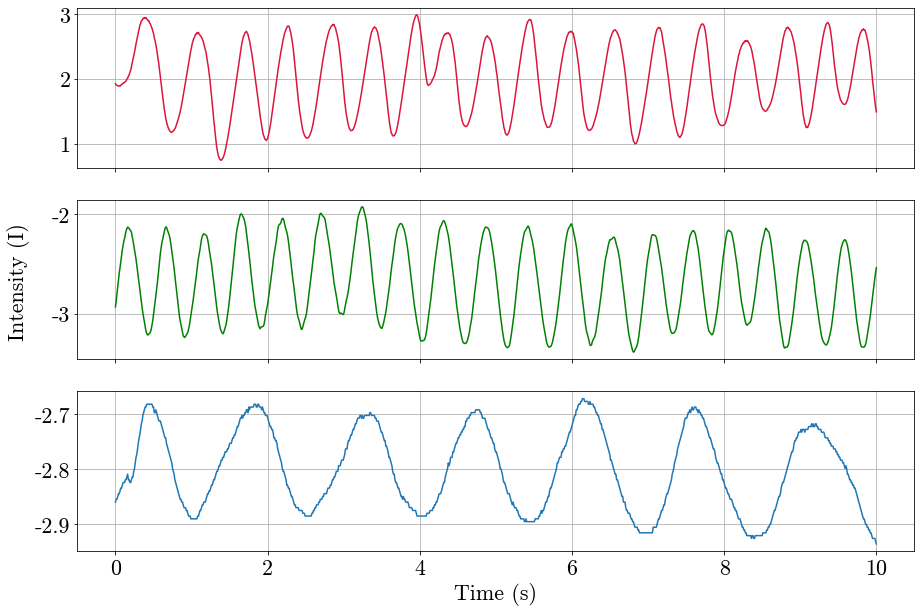

In [3]:
# --- Test plots for intensity --- 

fig, ax = plt.subplots(3, 
           sharex='col', sharey='row')

ax[0].plot(t, HeNe_Laser, color = 'crimson')
ax[0].grid()

ax[1].plot(t, Green_Laser, color = 'green')
ax[1].grid()

ax[2].plot(t, Blue_Laser)
ax[2].grid()

plt.xlabel('Time (s)')
fig.text(0.06, 0.5, 'Intensity (I)', va='center', rotation='vertical')

plt.show()

In [4]:
def PathDifference(data, time_motor, time_sample, sample_rate, distance): # Where distance is the start and end point of mirror over a time interval. 
    xt = distance/time_motor #returns the mirror speed in m/s for each travel. 
    dt = time_sample/sample_rate
    return xt*dt

In [5]:
# --- Calculating Path Lengths --- 

HeNe_Laser_PathDifference = PathDifference(HeNe_Laser, 621.5, 10, 1000, 3.567e-4)
print('Path Difference,', '{:.3}'.format(HeNe_Laser_PathDifference))
print('Minimum Wavelength,', '{:.3}'.format(HeNe_Laser_PathDifference*2))

Green_Laser_PathDifference = PathDifference(Green_Laser, 775, 10, 1000, 3.67e-4)
print('Path Difference,', '{:.3}'.format(Green_Laser_PathDifference))
print('Minimum Wavelength,', '{:.3}'.format(Green_Laser_PathDifference*2))

Blue_Laser_PathDifference = PathDifference(Blue_Laser, 1523, 10, 1000, 2.45e-4)
print('Path Difference,', '{:.3}'.format(Blue_Laser_PathDifference))
print('Minimum Wavelength,', '{:.3}'.format(Blue_Laser_PathDifference*2))

Path Difference, 5.74e-09
Minimum Wavelength, 1.15e-08
Path Difference, 4.74e-09
Minimum Wavelength, 9.47e-09
Path Difference, 1.61e-09
Minimum Wavelength, 3.22e-09


## Interferogram

In [6]:
def interferogram(data, path): 
    new_x = []
    for n in range(0, len(data)):
        new_x.append(0 + n*path)
    return new_x 

Text(0.5, 0, 'Path Difference')

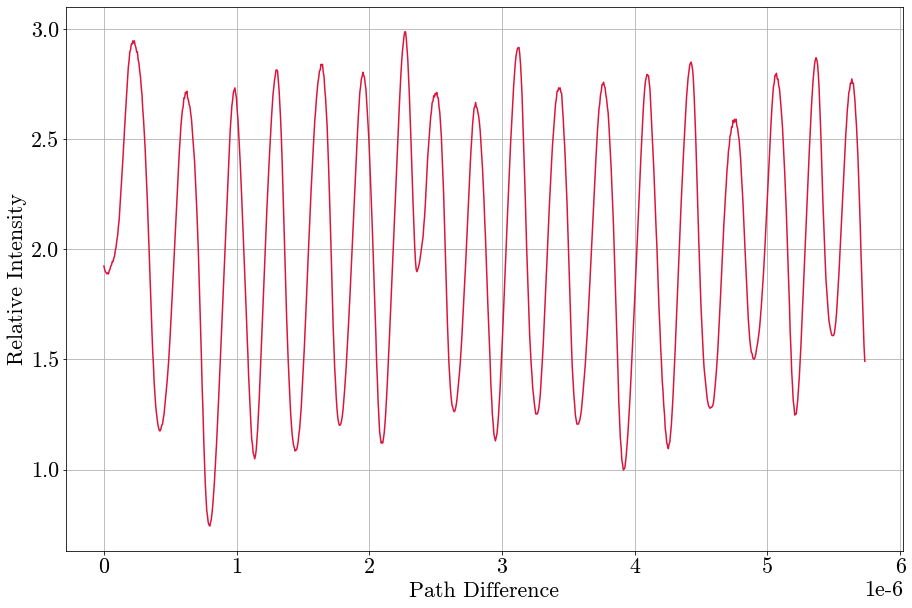

In [7]:
x = interferogram(HeNe_Laser, HeNe_Laser_PathDifference)

plt.plot(x, HeNe_Laser, color = 'crimson')
plt.grid()
plt.ylabel('Relative Intensity')
plt.xlabel('Path Difference')

Text(0.5, 0, 'Path Difference')

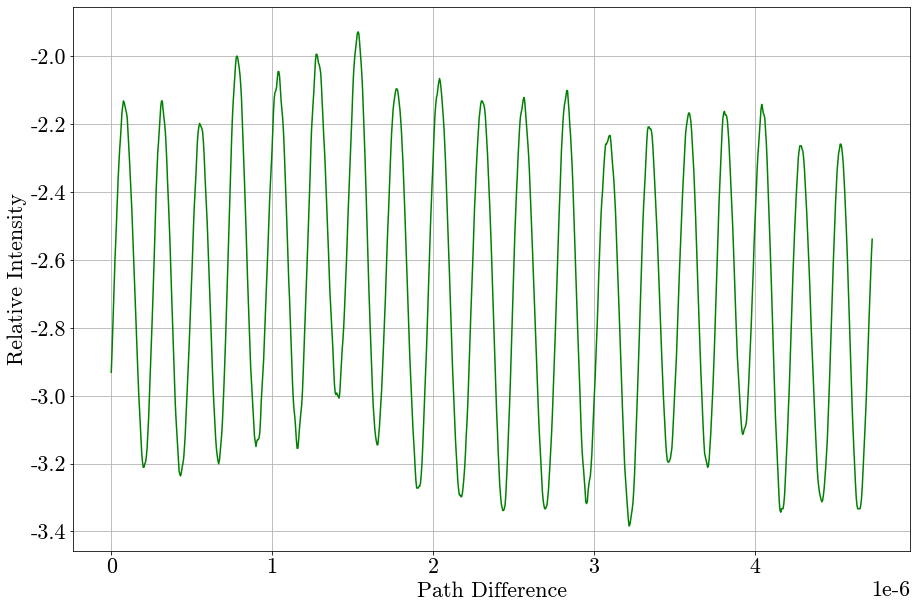

In [8]:
x = interferogram(Green_Laser, Green_Laser_PathDifference)

plt.plot(x, Green_Laser, color = 'Green')
plt.grid()
plt.ylabel('Relative Intensity')
plt.xlabel('Path Difference')

Text(0.5, 0, 'Path Difference')

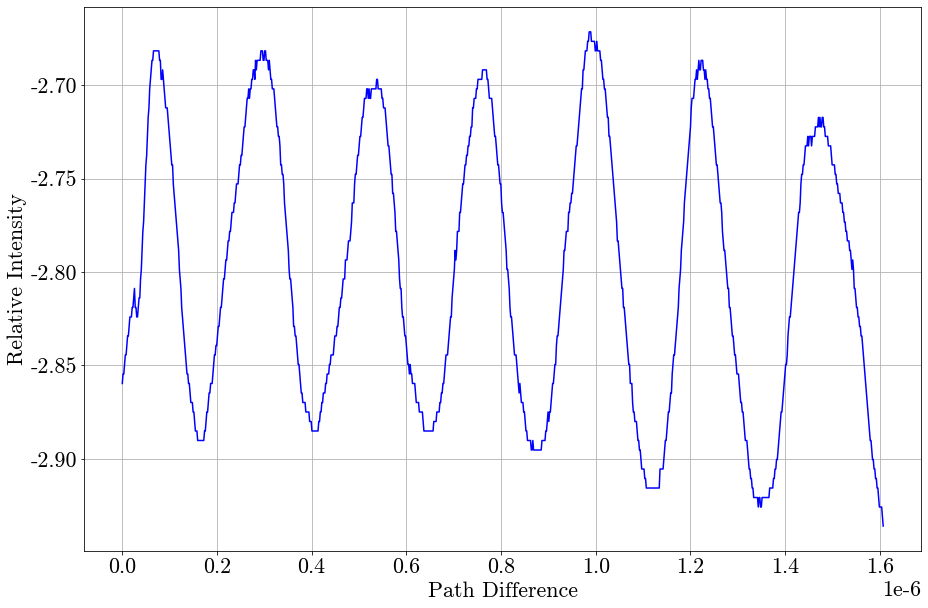

In [9]:
x = interferogram(Blue_Laser, Blue_Laser_PathDifference)

plt.plot(x, Blue_Laser, color = 'Blue')
plt.grid()
plt.ylabel('Relative Intensity')
plt.xlabel('Path Difference')

## Fast Fourier Transforms 

In [10]:
def freq(d_t, t_t, t_s, N):
     return (2*(d_t/t_t)*t_s)/N #Where, d_t is dist. travelled by motor, t_t travel duration, t_s sampling duration, N sample rate. 

def fft(data):
     ft_data = np.fft.fft(data)
     ft_amp = np.abs(ft_data)
     ft_freq = np.abs(np.fft.fftfreq(int(len(ft_data))))
     ft_waves = 1/ft_freq 
     return ft_data, ft_amp, ft_freq, ft_waves

$$\lambda \ = \ N\frac{\Delta x}{i} $$

In [11]:
def wavelength(dist, t, tsamp, N, ft_amp, a, b): 
    dx = (((2*dist)/t)*tsamp)/N

    λ = []
    Δλ = []

    for i in range(0, N):
        λv = N*(dx/(i + 1))
        Δλv = N*(dx/((i + 1)*(i + 2)))
        λ.append(λv)
        Δλ.append(Δλv)

    red = np.array(λ)*1e9 # --- scaling to nm for better illustration 
    Δλ = np.array(Δλ)*1e9

    na = []
    nw = []
    
    for i in range(0, len(red)):
        if a > red[i] > b:
            na.append(ft_amp[i])
            nw.append(red[i])

    ft_data_f = [na, nw]
    corresponding_λ = nw[np.argmax(ft_data_f[0])]
    print('corresponding λ is', '{:.3f}'.format(corresponding_λ), 'nm')

    x = (nw[np.argmax(ft_data_f[0])]/2)*(nw[np.argmax(ft_data_f[0])] - nw[np.argmax(ft_data_f[0]) + 1])

    return na, nw, corresponding_λ, Δλ, x 

In [12]:
ft_HeNe = fft(HeNe_Laser)
HeNe_Wavelength = wavelength(3.657e-4, 621.5, 10, 1000, ft_HeNe[1], 2000, 50)

ft_Green = fft(Green_Laser)
Green_Wavelength = wavelength(3.67e-4, 775, 10, 1000, ft_Green[1], 5000, 50)

ft_Blue = fft(Blue_Laser)
Blue_Wavelength = wavelength(2.45e-4, 1523, 10, 1000, ft_Blue[1], 3000, 50)

corresponding λ is 619.384 nm
corresponding λ is 473.548 nm
corresponding λ is 402.167 nm


(0.0, 1200.0)

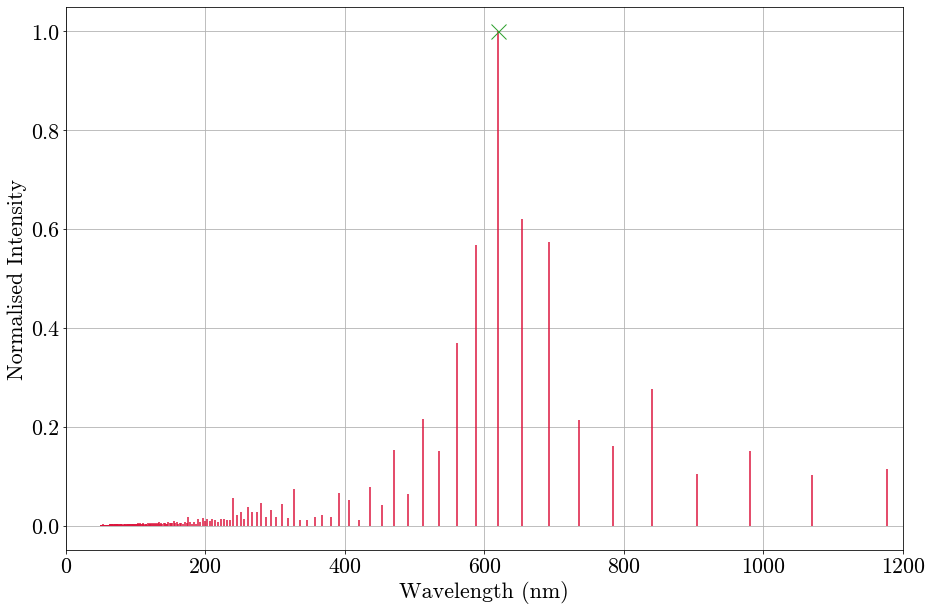

In [14]:
plt.stem(HeNe_Wavelength[1], HeNe_Wavelength[0]/(np.array(HeNe_Wavelength[0]).max()), markerfmt = " ", linefmt ='crimson', basefmt=" ")
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalised Intensity")
plt.plot(HeNe_Wavelength[2], 1, marker = 'x', markersize = 15)
# t = box_func(200, 1000)
# plt.plot(t[0], t[1], color = 'k')
plt.xlim(0, 1200)


(0.0, 1200.0)

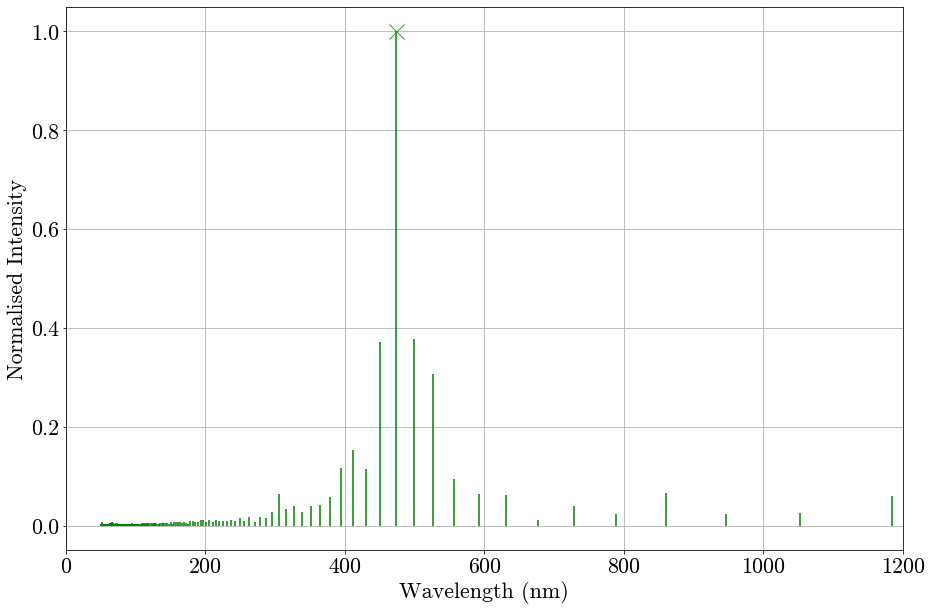

In [46]:

plt.stem(Green_Wavelength[1], Green_Wavelength[0]/np.array(Green_Wavelength[0]).max(), markerfmt = " ", linefmt ='green', basefmt=" ")
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalised Intensity")
# plt.plot(t[0], t[1], color = 'red')
plt.plot(Green_Wavelength[2], 1, marker = 'x', markersize = 15)
plt.xlim(0, 1200)

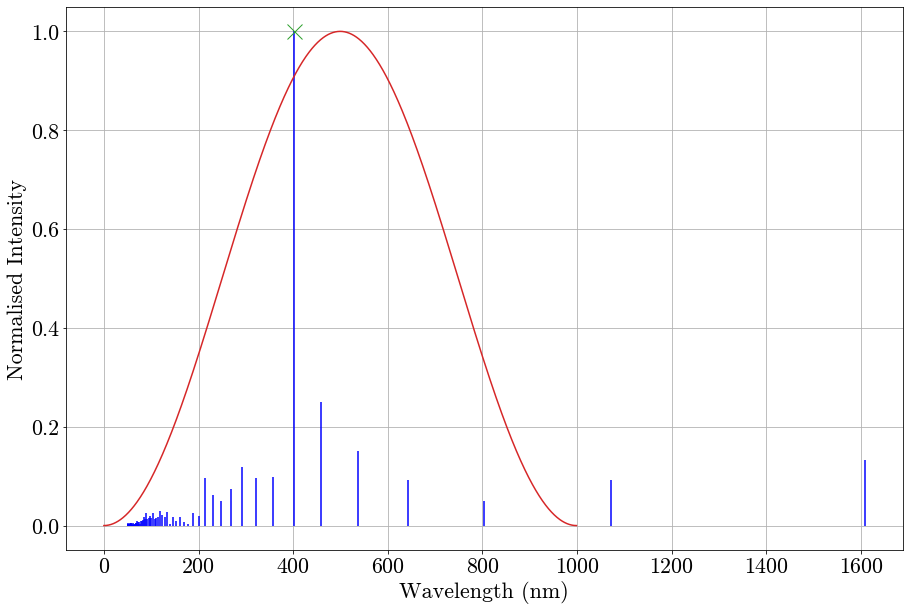

In [60]:
plt.stem(Blue_Wavelength[1], Blue_Wavelength[0]/np.array(Blue_Wavelength[0]).max(), markerfmt = " ", linefmt ='Blue', basefmt=" ")
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalised Intensity")
plt.plot(Blue_Wavelength[2], 1, marker = 'x', markersize = 15)
plt.plot(window)

## Analysis of Aliasing 

In [16]:
print('The wavelength for the HeNe wavelength was found to be,', '{:.3f}'.format((1 - (HeNe_Wavelength[2])/632.28)*100),'% smaller than expected.')
print('The wavelength for the Green wavelength was found to be,', '{:.3f}'.format((1 - (Green_Wavelength[2])/632.28)*100),'% smaller than expected.')
print('The wavelength for the Blue wavelength was found to be,', '{:.3f}'.format((1 - (Blue_Wavelength[2])/436)*100),'% smaller than expected.')

The wavelength for the HeNe wavelength was found to be, 2.040 % smaller than expected.
The wavelength for the Green wavelength was found to be, 25.105 % smaller than expected.
The wavelength for the Blue wavelength was found to be, 7.760 % smaller than expected.


In [17]:
print(HeNe_Wavelength[3].mean())
print(Green_Wavelength[3].mean())
print(Blue_Wavelength[3].mean())

11.756545948018191
9.461506235699783
3.2141200887097137


# $$ x \leq \frac{\lambda_1}{2} (\lambda_2 - \lambda_1) $$

In [18]:
print(HeNe_Wavelength[4])
print(Green_Wavelength[4])
print(Blue_Wavelength[4])

9590.924071294412
5339.239879094184
8985.450877694944


# Other Factor Calculations 

In [19]:
def min_resolvable_wavelength(n_t, wavelength, x_t, N):
    return (n_t*wavelength**2)/((x_t)*(N - 1)) #provides min resolvable wavelength.

def nyquist_criterion(x_t, n_t):
    return 2*(x_t/n_t)

def dx(dist, t, tsamp, N):
    return (((2*dist)/t)*tsamp)/N

In [55]:
# --- HeNe --- 

# --- Defining Parameters along with uncertainties --- 
d = ufloat(3.57e-4, 1.3e-6)
t = ufloat(621.5, 2)

#---
dx_HeNe = dx(d, t, 10, 1000)
HeNe_wl = min_resolvable_wavelength(100, HeNe_Wavelength[2], 100, 1000)

print('{:.3f}'.format(np.abs(HeNe_wl - 400)))
print(nyquist_criterion(100, 100))

15.979
2.0


Text(0.5, 0, 'Sample')

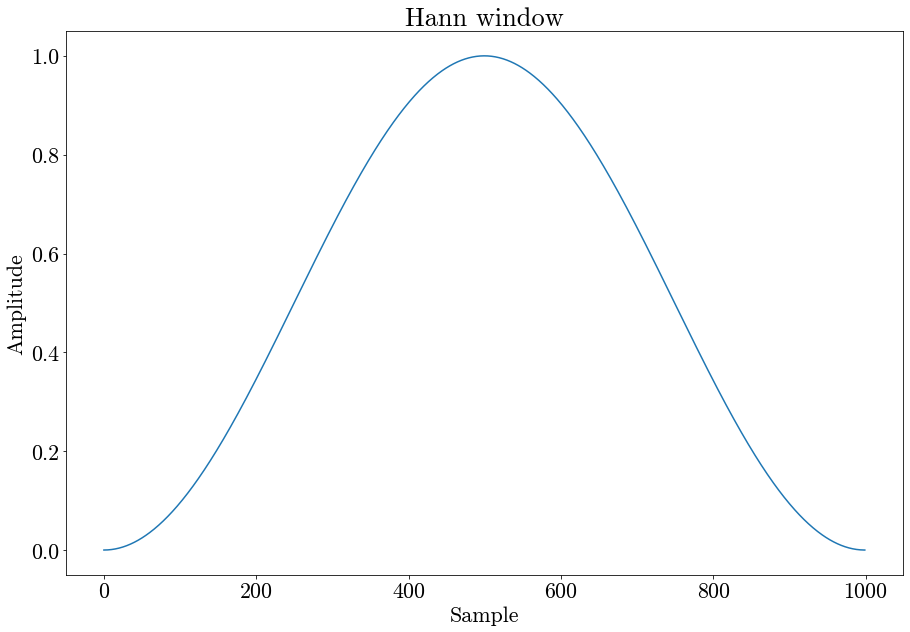

In [59]:
window = signal.hann(1000)
plt.plot(window)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

In [70]:
plt.figure()
A = fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Hann window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")

TypeError: fft() takes 1 positional argument but 2 were given